In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 99% 224M/226M [00:03<00:00, 77.9MB/s]
100% 226M/226M [00:03<00:00, 71.4MB/s]


In [2]:
!unzip "/content/butterfly-image-classification.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/Image_2348.jpg  
  inflating: /content/dataset/train/Image_2349.jpg  
  inflating: /content/dataset/train/Image_235.jpg  
  inflating: /content/dataset/train/Image_2350.jpg  
  inflating: /content/dataset/train/Image_2351.jpg  
  inflating: /content/dataset/train/Image_2352.jpg  
  inflating: /content/dataset/train/Image_2353.jpg  
  inflating: /content/dataset/train/Image_2354.jpg  
  inflating: /content/dataset/train/Image_2355.jpg  
  inflating: /content/dataset/train/Image_2356.jpg  
  inflating: /content/dataset/train/Image_2357.jpg  
  inflating: /content/dataset/train/Image_2358.jpg  
  inflating: /content/dataset/train/Image_2359.jpg  
  inflating: /content/dataset/train/Image_236.jpg  
  inflating: /content/dataset/train/Image_2360.jpg  
  inflating: /content/dataset/train/Image_2361.jpg  
  inflating: /content/dataset/train/Image_2362.jpg  
  inflating: /content/dataset/train/Image_2363.jpg

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers

In [4]:
df = pd.read_csv("/content/dataset/Training_set.csv")
df.head(10)

filename                     label
0   Image_1.jpg          SOUTHERN DOGFACE
1   Image_2.jpg                    ADONIS
2   Image_3.jpg            BROWN SIPROETA
3   Image_4.jpg                   MONARCH
4   Image_5.jpg  GREEN CELLED CATTLEHEART
5   Image_6.jpg           CAIRNS BIRDWING
6   Image_7.jpg  GREEN CELLED CATTLEHEART
7   Image_8.jpg      EASTERN DAPPLE WHITE
8   Image_9.jpg            BROWN SIPROETA
9  Image_10.jpg               RED POSTMAN

In [5]:
len(df)

6499

<ipython-input-6-93b3ac8be0e9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping wi

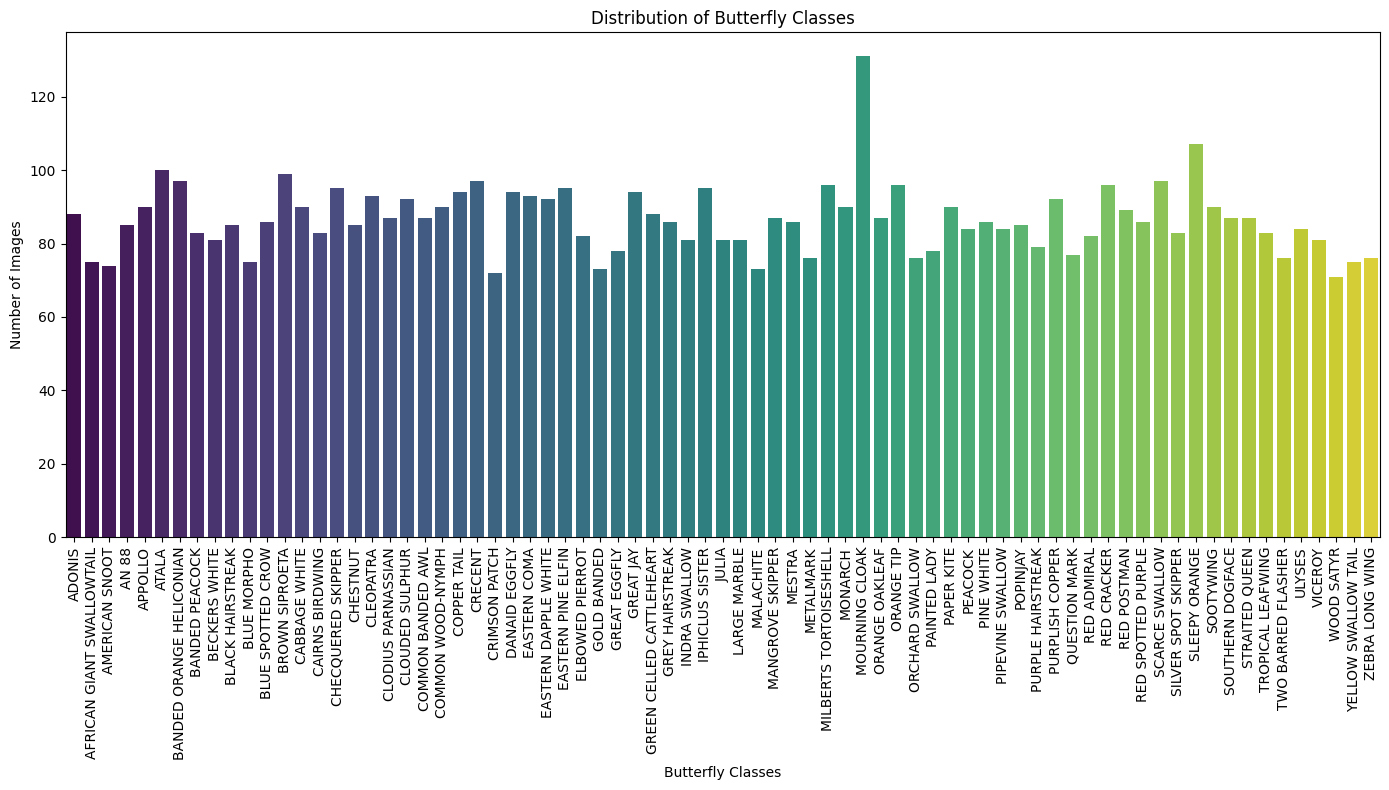

In [6]:
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

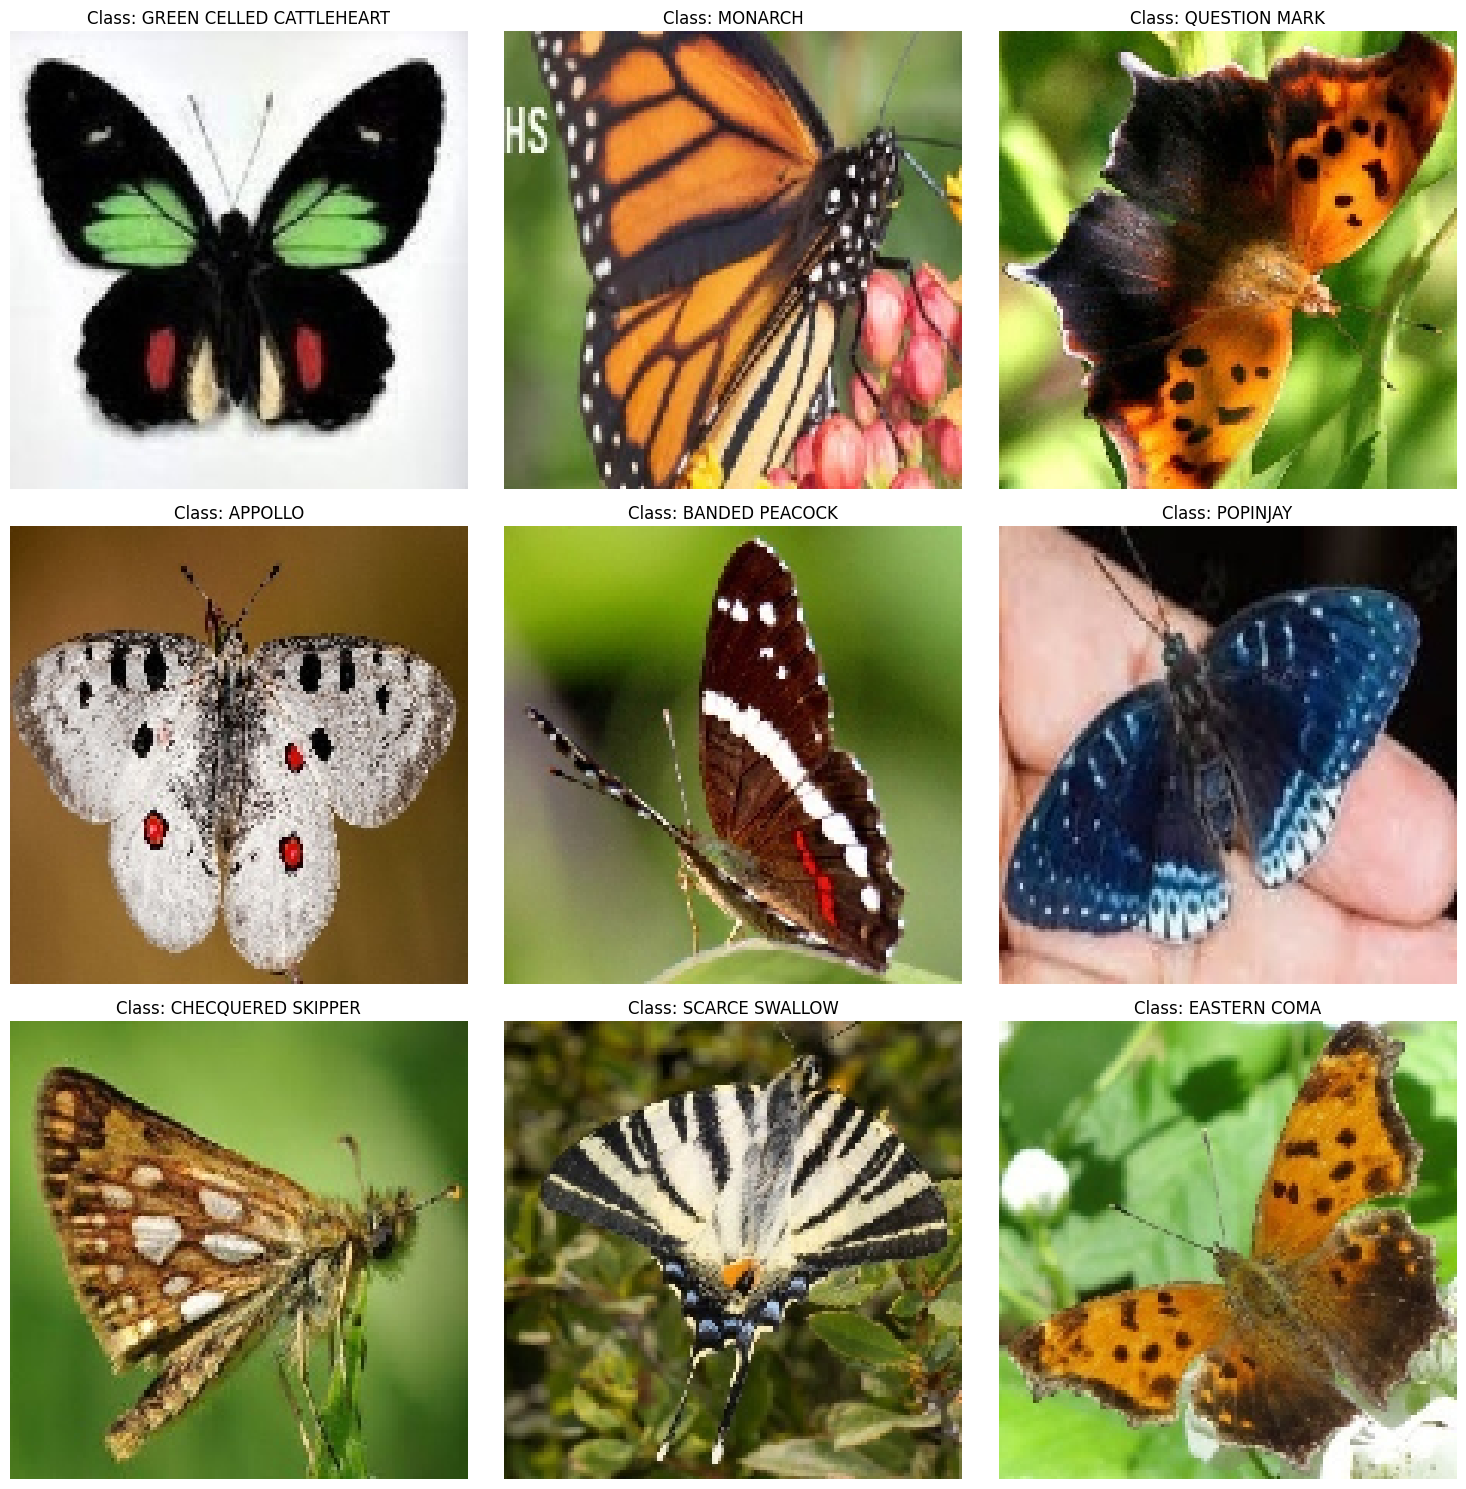

In [7]:
image_dir = "/content/dataset/train"

sample_images = df.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0

    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "/content/dataset/train"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [9]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75)                  │          38,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [11]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.0299 - loss: 4.2252
Epoch 1: val_loss improved from inf to 3.22156, saving model to best_weights.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 52s 258ms/step - accuracy: 0.0301 - loss: 4.2233 - val_accuracy: 0.1773 - val_loss: 3.2216
Epoch 2/40
  1/162 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.1250 - loss: 3.7188

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 3.22156 to 3.16461, saving model to best_weights.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1250 - loss: 3.7188 - val_accuracy: 0.2500 - val_loss: 3.1646
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.1651 - loss: 3.1969
Epoch 3: val_loss improved from 3.16461 to 2.80071, saving model to best_weights.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 70s 241ms/step - accuracy: 0.1654 - loss: 3.1959 - val_accuracy: 0.2883 - val_loss: 2.8007
Epoch 4/40
  1/162 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2500 - loss: 3.0680
Epoch 4: val_loss did not improve from 2.80071
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - accuracy: 0.2500 - loss: 3.0680 - val_accuracy: 0.3500 - val_loss: 2.9692
Epoch 5/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3222 - loss: 2.5172
Epoch 5: val_loss improved from 2.80071 to 2.18807, saving model to best_weights.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 0.3223 - loss: 

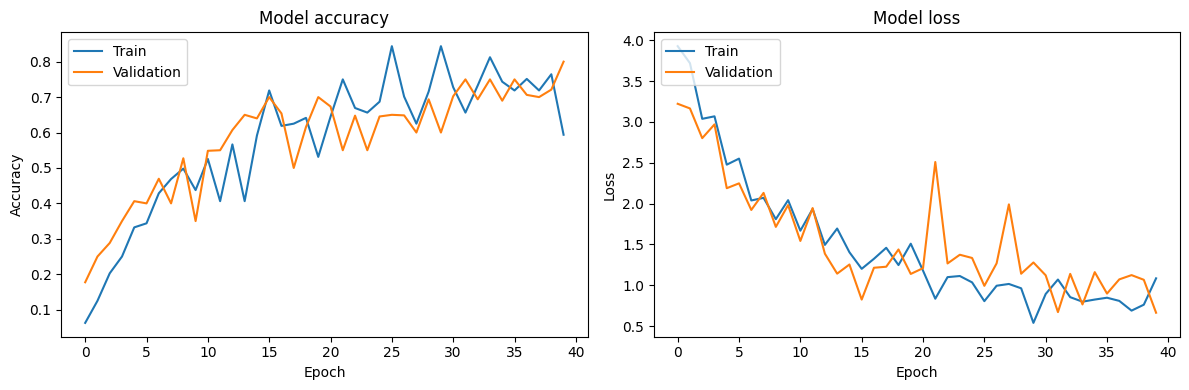

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


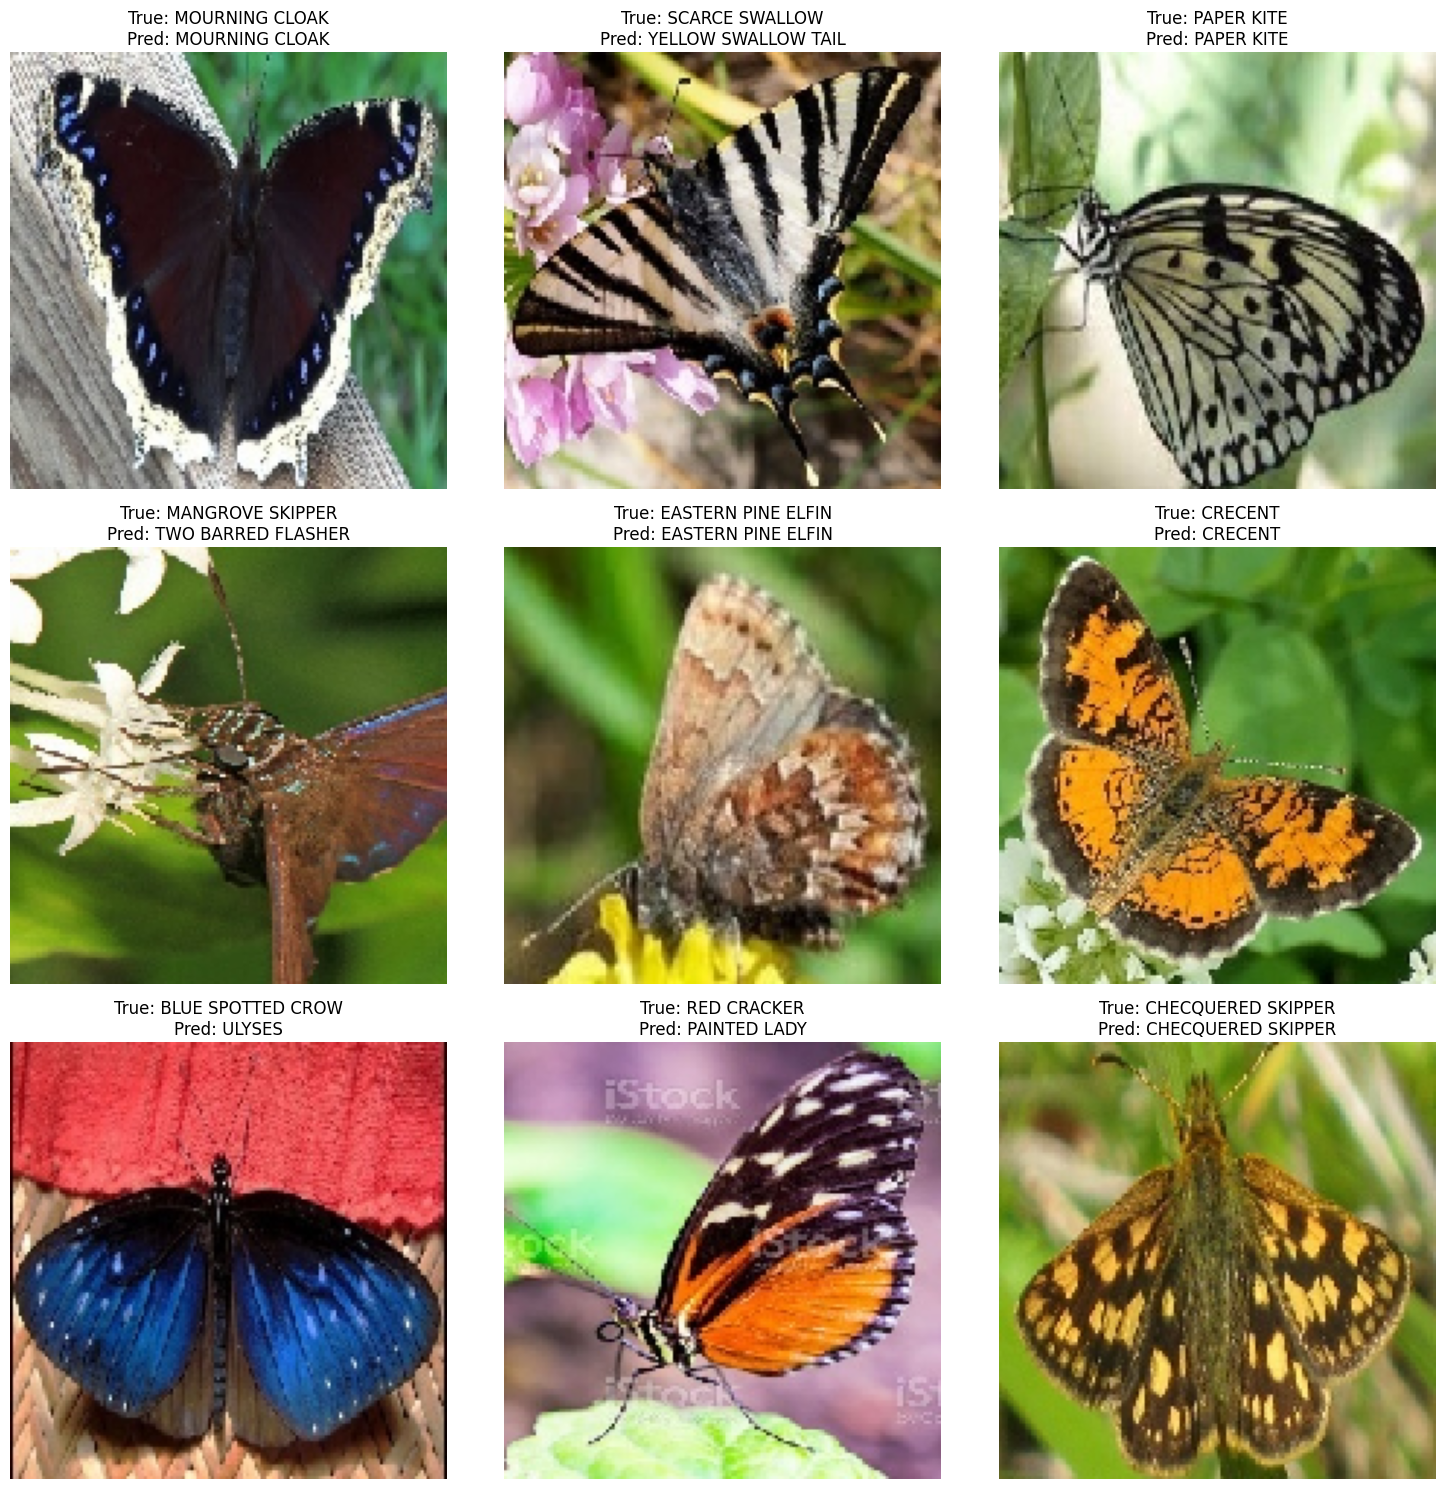

In [13]:
val_images, val_labels = next(val_generator)

model_CNN.load_weights('best_weights.keras')

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, pred_labels)
print("Accuracy:", accuracy)

precision = precision_score(true_labels, pred_labels, average='weighted')
print("Precision:", precision)

recall = recall_score(true_labels, pred_labels, average='weighted')
print("Recall:", recall)

f1 = f1_score(true_labels, pred_labels, average='weighted')
print("F1-score:", f1)

print(classification_report(true_labels, pred_labels))


Accuracy: 0.59375
Precision: 0.578125
Recall: 0.59375
F1-score: 0.5833333333333333
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         2
          14       0.00      0.00      0.00         0
          15       1.00      1.00      1.00         1
          18       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          22       1.00      1.00      1.00         1
          23       1.00      1.00      1.00         3
          25       0.00      0.00      0.00         1
          27       0.50      1.00      0.67         1
          28       1.00      1.00      1.00         1
          30       1.00      1.00      1.00         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

# Conclusion

Building a Convolutional Neural Network (CNN) for image recognition tasks highlights its ability to capture spatial patterns and hierarchies in images through layers of convolutions, pooling, and non-linear activations. CNNs excel over traditional machine learning methods for visual data processing due to their design, which reduces dimensionality efficiently while retaining crucial features.

### Applications of CNNs:
- Image and video recognition
- Object detection and segmentation
- Medical imaging analysis (e.g., MRI, X-rays)
- Autonomous vehicles (computer vision)
- Facial recognition

### Limitations of CNNs:
- Require large datasets to achieve optimal performance
- High computational and memory demands
- Less interpretable compared to simpler models